# Prototype 01
## Experiment 01

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [6]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [7]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique, Execution, Evaluation
from src.data_provider import DataProvider
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from prototypes.prototype_01.sensor_environment import SensorEnvironment
from prototypes.prototype_01.agent import Agent
from prototypes.prototype_01.client import Client
from prototypes.prototype_01.server import Server
from prototypes.prototype_01.experiment import Experiment

ModuleNotFoundError: No module named 'prototypes'

## --- Hyperparameters ---

In [8]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.0001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4

-----------
## Experiments 
### Experiment 01
#### Part 01

In [ ]:
import math

experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

TOTAL_NUMBER_OF_EPISODES = 10000
NR_ROUNDS = 10
NR_CLIENTS = list(range(1,11))

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

total_training_times = {}
round_training_times = {}

for execution in Execution:
    total_training_times[execution] = {}
    round_training_times[execution] = {}
    for nr_clients in NR_CLIENTS:
        
        nr_episodes_per_round = math.floor(TOTAL_NUMBER_OF_EPISODES / (NR_ROUNDS * nr_clients))
        
        print(f"nr_clients: {nr_clients}; execution: {execution}; nr_episodes_per_round: {nr_episodes_per_round}")

        environment = SensorEnvironment(train_data)
        global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
        # We want to train for n episodes when adding all episodes across all clients and rounds
        
        server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=nr_episodes_per_round)

        for unique_id in range(1, nr_clients + 1):
            environment = SensorEnvironment(train_data)
            agent = Agent(unique_id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)                               
            client = Client(unique_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)                                   
            server.add_client(client)

        server.run_federation(evaluations=[Evaluation.TRAINING_TIME], evaluation_frequency=10, verbose=False, document_results=False)
        total_training_times[execution][nr_clients] = server.total_training_time
        round_training_times[execution][nr_clients] = server.round_training_times

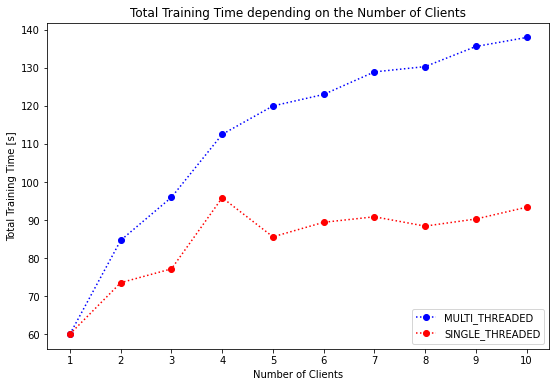

In [109]:
training_execution_times = {
    Execution.MULTI_THREADED: {1: 60.096912240982056, 2: 84.69177293777466, 3: 95.97647094726562, 4: 112.5046796798706, 5: 119.96393752098083, 6: 122.97974967956543, 7: 128.90417885780334, 8: 130.29015493392944,9: 135.57496786117554, 10: 137.94399547576904},
    Execution.SEQUENTIAL: {1: 60.085861587524414, 2: 73.55881094932556, 3: 77.18544721603394, 4: 95.86744952201843, 5: 85.5958263874054, 6: 89.41081714630127, 7: 90.85983729362488, 8: 88.41040182113647, 9: 90.274986743927, 10: 93.36574625968933}
}

colors = {
    Execution.SEQUENTIAL: '#FF0000',
    Execution.MULTI_THREADED: '#0000FF' ,
}

labels = {
    Execution.SEQUENTIAL: 'SINGLE_THREADED',
    Execution.MULTI_THREADED: 'MULTI_THREADED',
}

plt.figure(figsize=(9,6))
xlabel = "Number of Clients"
ylabel = "Total Training Time"
plt.xlabel(xlabel)
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} depending on the {xlabel}")
plt.xticks(np.arange(1, 11, 1))
#plt.figure(facecolor='white')
for execution_type, execution_times in training_execution_times.items():
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker='o', linestyle='dotted', label=labels[execution_type], color=colors[execution_type])
#plt.plot(list(multi_threaded_training_times.keys()), list(multi_threaded_training_times.values()), color="#0000FF", marker='o', linestyle='dashed', label='multi-threaded')
#plt.plot(list(single_threaded_training_times.keys()), list(single_threaded_training_times.values()), color="#FF0000", marker='o', linestyle='dashed', label='single-threaded')
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/total_training_time_anaylsis.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

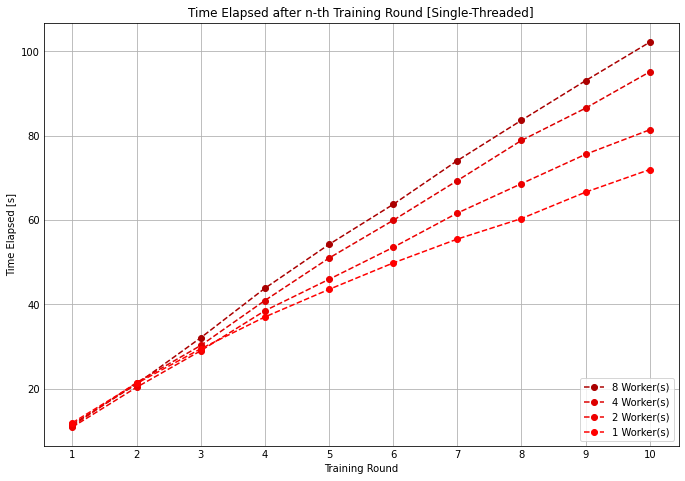

In [180]:
import matplotlib.pyplot as plt

single_threaded_training_times = {
    8: [11.481971979141235, 21.06865358352661, 32.05444097518921, 43.78777265548706, 54.19769239425659, 63.688286542892456, 74.07056212425232, 83.64049768447876, 93.04087591171265, 102.16776514053345],
    4: [11.134565114974976, 21.432404279708862, 30.219168186187744, 40.88900446891785, 50.95054054260254, 59.90651512145996, 69.32415723800659, 78.86217856407166, 86.5220353603363, 95.12839889526367],
    2: [10.868289709091187, 20.302647829055786, 28.97062063217163, 38.460485219955444, 45.914576292037964, 53.48994708061218, 61.6273672580719, 68.60588765144348, 75.56985259056091, 81.3848009109497],
    1: [11.893369436264038, 21.207906484603882, 29.435447692871094, 36.99051022529602, 43.52670192718506, 49.79359436035156, 55.46211814880371, 60.33178234100342, 66.59190773963928, 71.95667171478271]
}

colors = {
    1: "#FF0000",
    2: "#EE0000",
    4: "#DD0000",
    8: "#AA0000"
}

n_samples = len(single_threaded_training_times)
n_rounds = len(single_threaded_training_times[1])

plt.figure(figsize=(9,6))
xlabel = "Training Round"
ylabel = "Time Elapsed"
plt.xlabel(xlabel)
plt.xticks(np.arange(1, n_rounds+1))
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} after n-th {xlabel} [Single-Threaded]")

for number_of_workers, training_times in single_threaded_training_times.items():
    plt.plot(list(range(1,n_rounds+1)), list(training_times), color=colors[number_of_workers], marker="o", linestyle='dashed', label=f"{number_of_workers} Worker(s)")
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/round_training_time_analysis.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

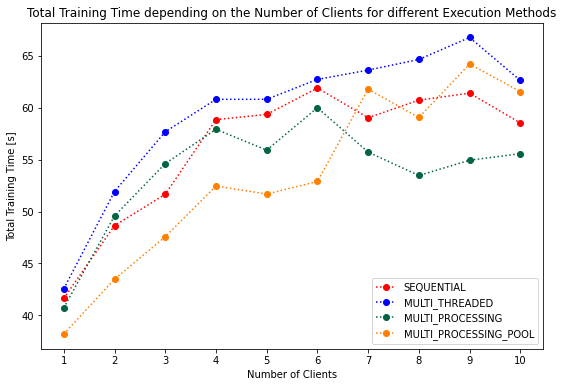

In [113]:
import matplotlib.pyplot as plt

training_execution_times = {
    Execution.SEQUENTIAL: {1: 41.64533591270447, 2: 48.645366191864014, 3: 51.65800380706787, 4: 58.84803819656372, 5: 59.35266900062561, 6: 61.889692068099976, 7: 59.03123378753662, 8: 60.72743010520935, 9: 61.397526025772095, 10: 58.53206706047058}, 
    Execution.MULTI_THREADED: {1: 42.561840295791626, 2: 51.92962908744812, 3: 57.67661094665527, 4: 60.804693937301636, 5: 60.808934020996094, 6: 62.72223496437073, 7: 63.61850380897522, 8: 64.643840074539185, 9: 66.76117181777954, 10: 62.622076988220215},
    Execution.MULTI_PROCESSING: {1: 40.726606130599976, 2: 49.579752922058105, 3: 54.61402606964111, 4: 57.9219069480896, 5: 55.913047075271606, 6: 59.99676012992859, 7: 55.721699237823486, 8: 53.472405195236206, 9: 54.939626932144165, 10: 55.5736198425293}, 
    Execution.MULTI_PROCESSING_POOL: {1: 38.21208715438843, 2: 43.48049211502075, 3: 47.57568597793579, 4: 52.455981969833374, 5: 51.68520402908325, 6: 52.89683985710144, 7: 61.78531098365784, 8: 59.05573129653931, 9: 64.20857810974121, 10: 61.55194592475891}
}

colors = {
    Execution.SEQUENTIAL: '#FF0000',
    Execution.MULTI_THREADED: '#0000FF' ,
    Execution.MULTI_PROCESSING: '#026440', 
    #Execution.MULTI_PROCESSING_POOL: '#FFD700',
    Execution.MULTI_PROCESSING_POOL: '#FF8000',
}


plt.figure(figsize=(9,6))
xlabel = "Number of Clients"
ylabel = "Total Training Time"
plt.xlabel(xlabel)
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} depending on the {xlabel} for different Execution Methods")
plt.xticks(np.arange(1, 11, 1))
#plt.figure(facecolor='white')
for execution_type, execution_times in training_execution_times.items():
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker='o', linestyle='dotted', label=execution_type.name, color=colors[execution_type])
#plt.plot(list(single_threaded_training_times.keys()), list(single_threaded_training_times.values()), color="#FF0000", marker='o', linestyle='dashed', label='single-threaded')
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/total_training_time_anaylsis_different_execution_methods.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

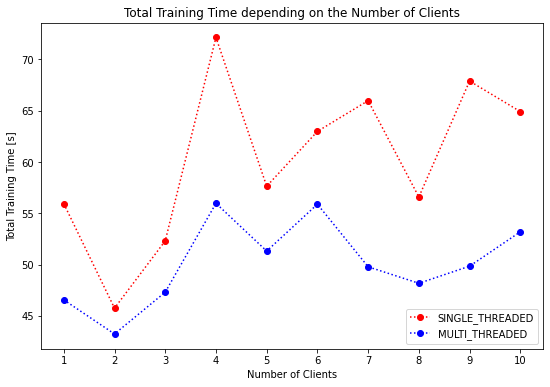

In [42]:
# When running the same experiment again after removing the call client.agent.online_net.share_memory()
# the result looks quite different
# Suddenly the multi threaded execution is much faster and even undercuts the sequential execution time
training_execution_times = {
    Execution.SEQUENTIAL: {1: 55.936387062072754, 2: 45.74790716171265, 3: 52.31152296066284, 4: 72.1409330368042, 5: 57.63561201095581, 6: 62.982574701309204, 7: 65.98179888725281, 8: 56.5855827331543, 9: 67.89041876792908, 10: 64.91327786445618}, 
    Execution.MULTI_THREADED: {1: 46.55751991271973, 2: 43.2324378490448, 3: 47.306280851364136, 4: 55.97371578216553, 5: 51.31317400932312, 6: 55.885953187942505, 7: 49.78178310394287, 8: 48.173242807388306, 9: 49.84343409538269, 10: 53.19402813911438}
}

colors = {
    Execution.SEQUENTIAL: '#FF0000',
    Execution.MULTI_THREADED: '#0000FF' ,
}

labels = {
    Execution.SEQUENTIAL: 'SINGLE_THREADED',
    Execution.MULTI_THREADED: 'MULTI_THREADED',
}

plt.figure(figsize=(9,6))
xlabel = "Number of Clients"
ylabel = "Total Training Time"
plt.xlabel(xlabel)
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} depending on the {xlabel}")
plt.xticks(np.arange(1, 11, 1))
#plt.figure(facecolor='white')
for execution_type, execution_times in training_execution_times.items():
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker='o', linestyle='dotted', label=labels[execution_type], color=colors[execution_type])
#plt.plot(list(multi_threaded_training_times.keys()), list(multi_threaded_training_times.values()), color="#0000FF", marker='o', linestyle='dashed', label='multi-threaded')
#plt.plot(list(single_threaded_training_times.keys()), list(single_threaded_training_times.values()), color="#FF0000", marker='o', linestyle='dashed', label='single-threaded')
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/total_training_time_anaylsis.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)
 
EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

behavior_subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK)
training_data_subset_1 = {x: training_data[x] for x in behavior_subset_1 if x in training_data}
environment_01 = SensorEnvironment(training_data_subset_1)

behavior_subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1, Behavior.CNC_OPT2)
training_data_subset_2 = {x: training_data[x] for x in behavior_subset_2 if x in training_data}
environment_02 = SensorEnvironment(training_data_subset_2)

datasets = {
    "Global Behavior Distribution": training_data, 
    "Behavior Distribution on Client 1": training_data_subset_1,
    "Behavior Distribution on Client 2": training_data_subset_2
}

for title, dataset in datasets.items():
    sample_distribution = {behavior: 0 for behavior in Behavior}
    for k, v in dataset.items():
         sample_distribution[k] = len(v)

    plt.bar(range(len(sample_distribution)), list(sample_distribution.values()), align='center', color='blue')
    plt.xticks(range(len(sample_distribution)), list(sample_distribution.keys()))
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel('n_samples')
    plt.savefig(f"{title}.jpg", bbox_inches="tight")
    plt.show()



global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

#server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.TIME], evaluation_frequency=1, verbose=True, document_results=True)

In [ ]:
for id in range(3):
    for behavior in Behavior:
        performance = server.client_performance[id][behavior]
        plt.title(f"Client {id}")
        plt.plot([*range(len(performance))], performance) # plotting t, a separately 
    plt.show()

In [ ]:
for behavior in Behavior:
    for id in range(3):
        performance = server.client_performance[id][behavior]
        plt.title(f"Behavior {behavior.value}")
        plt.ylim([0,100])
        if id == 0:
            plt.plot([*range(len(performance))], performance, linestyle='-') # plotting t, a separately 
        else:
            plt.plot([*range(len(performance))], performance, linestyle='--') # plotting t, a separately 
    plt.show()